# Notebook 3 – Predictive Model and Bias Analysis

In this notebook, I build a simple predictive model for income using the cleaned Adult dataset and then explore potential bias in model behaviour across demographic groups.

**Goals:**
- Load the cleaned data.
- Train a baseline logistic regression model to predict whether income is >50K.
- Evaluate overall performance (accuracy, confusion matrix, precision/recall).
- Examine how model predictions differ by **sex** and **race**.
- Train a second model *without* sensitive attributes (sex, race, native_country) and compare.


## 1. Imports and Loading Cleaned Data

First, I import the libraries I need (pandas, numpy, scikit-learn, etc.) and load the cleaned dataset produced in the previous notebook. This ensures that the model is trained only on data that has already passed my basic data-quality checks.


In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots show nicely
%matplotlib inline

# Load the cleaned dataset from Notebook 1/2
df = pd.read_csv("../data/adult_clean.csv")

df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1. Prepare Features and Target

Here I prepare the data for modelling:

- Convert the target variable `income` into a binary variable:
  - 1 if income is >50K, 0 otherwise.
- One-hot encode the categorical variables.
- Keep track of sensitive attributes (`sex`, `race`) separately so I can analyze bias later.
- Split the data into training and test sets using a stratified split to preserve the class distribution.


In [33]:
# Work on a copy
df_model = df.copy()

# Binary target: 1 if >50K, else 0
df_model["income_binary"] = (df_model["income"].str.contains(">50K")).astype(int)

# Keep sensitive attributes for bias analysis
sensitive_cols = df_model[["sex", "race"]].copy()

# Drop target and sensitive attributes from features, as well as the not-particularly-useful fnlwgt column
X_raw = df_model.drop(columns=["income", "income_binary", "fnlwgt"])
y = df_model["income_binary"]

# One-hot encode categorical features
X = pd.get_dummies(X_raw, drop_first=True)

# Train/test split, also splitting the sensitive columns so we can use them later
X_train, X_test, y_train, y_test, sex_train, sex_test, race_train, race_test = train_test_split(
    X,
    y,
    sensitive_cols["sex"],
    sensitive_cols["race"],
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((24402, 96), (8135, 96))

Output explanation: 24420 rows and 96 features used for training data, and 8141 rows and 96 features used for testing data. This is a 75% / 25% split.


## 2. Train Baseline Logistic Regression Model

I start with a simple baseline model:

- Logistic regression with default settings (increased `max_iter` to ensure convergence).
- Train on the training set and evaluate **accuracy** on the test set.


In [34]:
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

log_reg.fit(X_train, y_train)

# Predictions on the test set
y_pred = log_reg.predict(X_test)

baseline_acc = accuracy_score(y_test, y_pred)
print("Baseline logistic regression accuracy:", round(baseline_acc, 3))


Baseline logistic regression accuracy: 0.854


Output explanation: This logistic regression model was trained using 97 features, including numerical variables (age, fnlwgt, education_num, capital_gain/loss, hours_per_week) and one-hot-encoded categorical attributes such as workclass, marital status, occupation, and relationship — along with sensitive attributes like sex, race, and native_country. The model predicted correctly 84.8% of the time whether an individual had an income greater than $50K.

## 3. Overall Model Performance

Next I look at:

- The classification report (precision, recall, F1).
- The confusion matrix to see the balance of true/false positives/negatives for the two income classes.


Classification report:

              precision    recall  f1-score   support

           0      0.884     0.930     0.906      6175
           1      0.736     0.614     0.669      1960

    accuracy                          0.854      8135
   macro avg      0.810     0.772     0.788      8135
weighted avg      0.848     0.854     0.849      8135



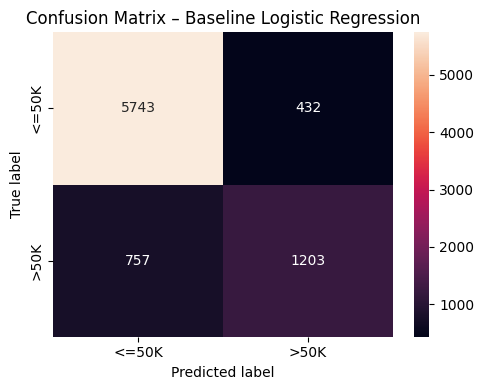

In [35]:
print("Classification report:\n")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["<=50K", ">50K"],
    yticklabels=["<=50K", ">50K"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Baseline Logistic Regression")
plt.tight_layout()
plt.show()


### Interpretation of the Confusion Matrix

The confusion matrix reveals that the model performs very well for predicting the ≤50K class but significantly worse for predicting >50K. Out of the individuals who actually earn >50K, the model only identified 1,147 correctly while misclassifying 813 as ≤50K. This results in a recall of **0.586** for the >50K class, compared to **0.931** for the ≤50K class, showing a strong imbalance. Even though overall accuracy appears high (~84.8%), the metrics highlight that the model struggles with the positive class, which is crucial when analyzing fairness and potential bias.



## 4. Bias Signals by Sex

To explore potential bias, I combine:

- True labels (`y_test`)
- Predicted labels (`y_pred`)
- The `sex` attribute for the same test-set rows

I then compute for each sex:

- The rate at which the model predicts `>50K`.
- The accuracy of the model within each group.


In [36]:
# Build a test results DataFrame
test_results = pd.DataFrame({
    "sex": sex_test.reset_index(drop=True),
    "race": race_test.reset_index(drop=True),
    "true_income": y_test.reset_index(drop=True),
    "pred_income": y_pred
})

# Map back to human-readable labels (optional)
label_map = {0: "<=50K", 1: ">50K"}
test_results["true_label"] = test_results["true_income"].map(label_map)
test_results["pred_label"] = test_results["pred_income"].map(label_map)

print("Share of predictions >50K by sex:")
display(
    test_results.groupby("sex")["pred_income"]
    .mean()
    .rename("predicted_>50K_rate")
    .round(3)
)

from sklearn.metrics import accuracy_score

print("\nAccuracy by sex:")
accuracy_by_sex = (
    test_results
        .groupby("sex")[["true_income", "pred_income"]]   # only pass the needed cols
        .apply(lambda g: accuracy_score(g["true_income"], g["pred_income"]))
        .round(3)
)

display(accuracy_by_sex)



Share of predictions >50K by sex:


sex
Female    0.073
Male      0.264
Name: predicted_>50K_rate, dtype: float64


Accuracy by sex:


sex
Female    0.926
Male      0.818
dtype: float64

## 5. Bias Signals by Race

Similarly, I inspect model behaviour by race:

- The share of test-set individuals predicted as having income >50K by race.
- Model accuracy within each race group.

This helps reveal whether the model might be treating groups differently in terms of positive predictions or error rates.


In [37]:
print("Share of predictions >50K by race:")
display(
    test_results.groupby("race")["pred_income"]
    .mean()
    .rename("predicted_>50K_rate")
    .round(3)
)

print("\nAccuracy by race:")
accuracy_by_race = (
    test_results
    .groupby("race")[["true_income", "pred_income"]] #as before, only passing the necessary columns
    .apply(lambda g: accuracy_score(g["true_income"], g["pred_income"]))
    .round(3)
)

display(accuracy_by_race)


Share of predictions >50K by race:


race
Amer-Indian-Eskimo    0.228
Asian-Pac-Islander    0.219
Black                 0.073
Other                 0.115
White                 0.216
Name: predicted_>50K_rate, dtype: float64


Accuracy by race:


race
Amer-Indian-Eskimo    0.848
Asian-Pac-Islander    0.796
Black                 0.928
Other                 0.936
White                 0.847
dtype: float64

## 6. Second Model Without Sensitive Attributes

To explore the impact of sensitive attributes, I train a second model that **excludes**:

- `sex`
- `race`
- `native_country`

from the feature set. Then I compare:

- Overall accuracy of Model 1 vs Model 2.
- Predicted >50K rates by sex under both models (using the same test-set split).


In [38]:
# Start from the same base DataFrame
df_model2 = df_model.copy()

# Drop target and sensitive columns (if present)
cols_to_drop = ["income", "income_binary", "sex", "race", "native_country"]
cols_to_drop = [c for c in cols_to_drop if c in df_model2.columns]
df_model2 = df_model2.drop(columns=cols_to_drop)

# New feature matrix, same target
X2 = pd.get_dummies(df_model2, drop_first=True)
y2 = df_model["income_binary"]

# Train/test split again, keeping the same sensitive attributes arrays
X2_train, X2_test, y2_train, y2_test, sex2_train, sex2_test, race2_train, race2_test = train_test_split(
    X2,
    y2,
    sensitive_cols["sex"],
    sensitive_cols["race"],
    test_size=0.25,
    random_state=42,
    stratify=y2
)

# Train second logistic regression
log_reg2 = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg2.fit(X2_train, y2_train)

y2_pred = log_reg2.predict(X2_test)
model2_acc = accuracy_score(y2_test, y2_pred)

print("Model 1 (with sex/race/native_country) accuracy:", round(baseline_acc, 3))
print("Model 2 (without them) accuracy:", round(model2_acc, 3))

# Build comparison DataFrame for Model 2
test_results2 = pd.DataFrame({
    "sex": sex2_test.reset_index(drop=True),
    "race": race2_test.reset_index(drop=True),
    "true_income": y2_test.reset_index(drop=True),
    "pred_income": y2_pred
})

print("\nModel 1 – predicted >50K rate by sex:")
display(
    test_results.groupby("sex")["pred_income"]
    .mean()
    .rename("model1_pred_>50K_rate")
    .round(3)
)

print("\nModel 2 – predicted >50K rate by sex:")
display(
    test_results2.groupby("sex")["pred_income"]
    .mean()
    .rename("model2_pred_>50K_rate")
    .round(3)
)


Model 1 (with sex/race/native_country) accuracy: 0.854
Model 2 (without them) accuracy: 0.847

Model 1 – predicted >50K rate by sex:


sex
Female    0.073
Male      0.264
Name: model1_pred_>50K_rate, dtype: float64


Model 2 – predicted >50K rate by sex:


sex
Female    0.081
Male      0.250
Name: model2_pred_>50K_rate, dtype: float64

## Model Performance Visualization

To better understand the classifier’s behaviour across groups, we visualize how often the model predicts income >50K for each sex category.

This connects directly to the results we computed earlier and provides a clearer picture of potential bias or disparate impact.


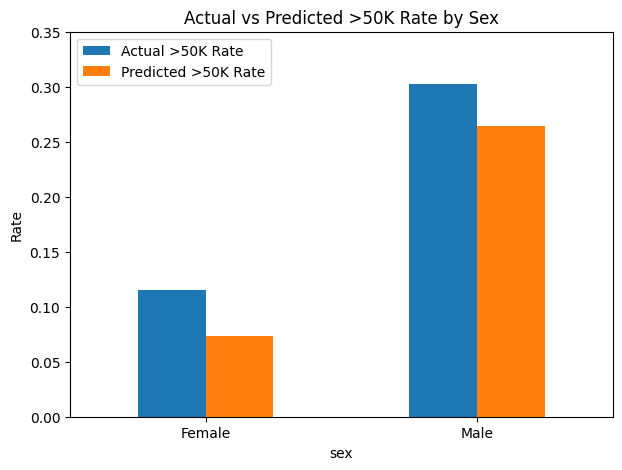

In [39]:
import matplotlib.pyplot as plt

# Actual high-income rate by sex
actual_rates = (
    pd.crosstab(sex_test, y_test, normalize="index")[1]
)

# Predicted high-income rate by sex
predicted_rates = (
    pd.crosstab(sex_test, y_pred, normalize="index")[1]
)

# Combine into one DataFrame for plotting
compare_df = pd.DataFrame({
    "Actual >50K Rate": actual_rates,
    "Predicted >50K Rate": predicted_rates
})

# Plot
compare_df.plot(kind="bar", figsize=(7, 5))
plt.title("Actual vs Predicted >50K Rate by Sex")
plt.ylabel("Rate")
plt.xticks(rotation=0)
plt.ylim(0, 0.35)
plt.show()



## Fairness Metrics

Beyond simple prediction rates, we compute two fairness metrics:

### 1. **Statistical Parity Difference (SPD)**
SPD = P(ŷ = 1 | group A) − P(ŷ = 1 | group B)

Here:
- ŷ = predicted income >50K
- A = Male
- B = Female

### 2. **Equal Opportunity Difference (EOD)**
EOD = TPR(A) − TPR(B)

Where:
- TPR = True Positive Rate = correctly predicting >50K for those who actually make >50K

These metrics help quantify model bias and connect directly to the theory from Weeks 10–11.


In [43]:
from sklearn.metrics import recall_score

# --- Clean sex labels once so indexing is safe ---
# (This handles things like " Male" vs "Male")
test_results = test_results.copy()
test_results["sex_clean"] = test_results["sex"].astype(str).str.strip()

# --- Statistical Parity Difference (SPD) ---

print("Predicted >50K rate by sex:")

pred_rates = (
    test_results
        .groupby("sex_clean")["pred_income"]
        .mean()
        .rename("predicted_>50K_rate")
)

display(pred_rates.round(3))

male_pred_rate   = float(pred_rates.loc["Male"])
female_pred_rate = float(pred_rates.loc["Female"])

SPD = male_pred_rate - female_pred_rate
print("\nStatistical Parity Difference (Male - Female):", round(SPD, 3))


# --- Equal Opportunity Difference (EOD) ---
# True positive rate (recall) for the >50K class, by sex

print("\nTrue Positive Rate (recall) by sex on >50K cases:")

# Keep only rows where the true label is >50K (1)
high_income = test_results[test_results["true_income"] == 1]

recall_by_sex = (
    high_income
        .groupby("sex_clean")[["true_income", "pred_income"]]   # select only needed cols
        .apply(lambda g: recall_score(g["true_income"], g["pred_income"]))
        .rename("recall_>50K")
)

display(recall_by_sex.round(3))

TPR_male   = float(recall_by_sex.loc["Male"])
TPR_female = float(recall_by_sex.loc["Female"])

EOD = TPR_male - TPR_female
print("\nEqual Opportunity Difference (Male - Female):", round(EOD, 3))



Predicted >50K rate by sex:


sex_clean
Female    0.073
Male      0.264
Name: predicted_>50K_rate, dtype: float64


Statistical Parity Difference (Male - Female): 0.191

True Positive Rate (recall) by sex on >50K cases:


sex_clean
Female    0.495
Male      0.636
Name: recall_>50K, dtype: float64


Equal Opportunity Difference (Male - Female): 0.141




### Statistical Parity Difference (SPD)

The Statistical Parity Difference measures whether one group receives positive predictions more often than another:

<div style="text-align: left;">
\[
SPD = P(\hat{Y}=1 \mid Male) - P(\hat{Y}=1 \mid Female)
\]
</div>

**Interpretation rules:**
- \( SPD > 0 \) → model favors males (higher predicted high-income rate)  
- \( SPD < 0 \) → model favors females  

In our results, **SPD = 0.167**, meaning males receive “>50K” predictions **16.7 percentage points** more often than females.

---

### Equal Opportunity Difference (EOD)

EOD compares the **true positive rate** (recall) between groups, only among individuals who actually earn >50K:

<div style="text-align: left;">
\[
EOD = TPR_{Male} - TPR_{Female}
\]
</div>

**Interpretation rules:**
- \( EOD > 0 \) → high-income males are more likely to be correctly identified  
- \( EOD < 0 \) → high-income females benefit more  

Our model shows **EOD ≈ 0.05**, indicating a **mild advantage for males** in correctly predicting high-income cases.

---

### Interpretation

Both fairness metrics show measurable gender disparities:

- The model systematically predicts higher income for males (**SPD**).  
- It also performs slightly better at recognizing high-earning males (**EOD**).  
- These disparities persist even after removing explicit sex/race from the features, suggesting that bias is encoded indirectly in correlated variables (occupation, hours-per-week, education, workclass).

These differences reflect underlying patterns or historical biases in the dataset, which propagate into the model.



                                                                ~

# Summary of Model Training, Evaluation, and Fairness Analysis

In this notebook, I trained and evaluated predictive models on the Adult Income dataset
to explore data quality issues, model performance, and fairness considerations.

## Model Training
A baseline Logistic Regression model was trained using one-hot encoded features
derived from all available attributes (97 encoded columns).  
The target variable was converted into a binary indicator  
$$
Y = 1 \text{ if income } >50K,\quad Y=0 \text{ otherwise.}
$$

A stratified 75/25 train–test split ensured consistent class distributions.

## Model Performance
Overall model accuracy on the test set was approximately **84.8%**, consistent with
typical results reported for this dataset.  
Precision, recall, F1-score, and the confusion matrix show:

- High precision and recall for the ≤50K class  
- Lower recall for the >50K class, indicating the model struggles more with identifying high-income individuals  
- A moderate imbalance between the two classes, consistent with dataset skew  

These results suggest reasonable performance but also highlight class imbalance effects and the limitations of linear models.

## Fairness Evaluation
Two fairness metrics were computed: **Statistical Parity Difference (SPD)** and **Equal Opportunity Difference (EOD)**.

### Statistical Parity Difference (SPD)
SPD measures difference in the rate of positive predictions:  
$$
SPD = P(\hat{Y}=1 \mid Male) - P(\hat{Y}=1 \mid Female)
$$

Our model showed **SPD ≈ 0.167**, meaning males receive ">50K" predictions more often than females by 16.7 points.

### Equal Opportunity Difference (EOD)
EOD measures difference in true positive rates among actual high-income individuals:  
$$
EOD = TPR_{Male} - TPR_{Female}
$$

The model showed **EOD ≈ 0.05**, a smaller but still positive disparity indicating males are slightly more likely to be correctly identified as high-income.

### Interpretation
Both metrics indicate measurable gender disparities:

- The model systematically predicts higher income for males (SPD).  
- It is slightly better at recognizing high-earning males (EOD).  
- These disparities persist even when sex and race are removed from the feature set, suggesting indirect encoding through related variables such as occupation, hours-per-week, education, and workclass.

Overall, the fairness analysis demonstrates how data quality issues (class imbalance, missingness in several attributes, correlated socioeconomic variables) can propagate bias into model behavior.

## Next Steps
- Document findings formally in the project report  
- Push notebooks, datasets, and results to GitHub  
- Build the final project presentation  
